In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.display import Image

from sklearn.preprocessing import MinMaxScaler

pd.options.display.max_colwidth = 250

In [2]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import plotly.express as px

# load tweets data

In [3]:
#load tweets data. large file, slowish. 
tweets = pd.read_parquet('/data_volume/pub/antivax/labeled_geotagged_tweets.parquet')

#make clean date column
tweets['date'] = tweets['tweet_time'].dt.floor('d')

In [4]:
# #add misinfo codes to tweets

# urls_folder = '/data_volume/live/intermediate_files/data-processing/urls_daily/'
# high_tids = pickle.load(open(urls_folder+'daily_high_tids.pkl','rb'))
# low_tids = pickle.load(open(urls_folder+'daily_low_tids.pkl','rb'))

# misinfo_codes = list()
# for date in high_tids:
#     for tid in high_tids[date]:
#         misinfo_codes.append((tid,0))
# for date in low_tids:
#     for tid in low_tids[date]:
#         misinfo_codes.append((tid,1))
# misinfo_codes = pd.DataFrame(misinfo_codes,columns = ['tweet_id','is_low_credibility'])
# misinfo_codes['tweet_id'] = misinfo_codes['tweet_id'].astype(int)

# tweets = tweets.merge(misinfo_codes, on='tweet_id',how='left')
# del high_tids; del low_tids; del misinfo_codes

# prepare antivax df

In [5]:
def get_users_labels(tweets):
    antivax_counts = pd.DataFrame(tweets[tweets['is_antivax']==1]['user_id'].value_counts()).reset_index().rename(columns = {'user_id':'antivax_tweets','index':'user_id'})
    non_antivax_counts = pd.DataFrame(tweets[tweets['is_antivax']==0]['user_id'].value_counts()).reset_index().rename(columns = {'user_id':'non_antivax_tweets','index':'user_id'})
    tweet_counts = non_antivax_counts.merge(antivax_counts, on='user_id', how='outer').fillna(0)
    tweet_counts['user_is_antivax'] = (tweet_counts['antivax_tweets'] > (tweet_counts['non_antivax_tweets']))
    users_labels = tweet_counts[['user_id','user_is_antivax']]
    return users_labels


#get tweet counts by county and date
antivax_tweets = tweets[['is_antivax',#'is_low_credibility',
                         'FIPS','date']].groupby(['FIPS','date']).agg(['sum','count'])
antivax_tweets.columns = [' '.join(col).strip() for col in antivax_tweets.columns.values] #flatten columns index
antivax_tweets = antivax_tweets.rename(columns = {'is_antivax sum':'n_antivax_tweets_on_day',
                                                    'is_antivax count':'n_tweets_on_day',
#                                                     'is_low_credibility sum': 'n_lowcred_urls_on_day',
#                                                     'is_low_credibility count': 'n_urls_on_day'
                                                 }).reset_index()

#get retweet_couts
antivax_retweets = tweets[tweets['retweeted_tweet_id']!=-1][['is_antivax','FIPS','date']].groupby(['FIPS','date']).agg(['sum','count'])
antivax_retweets.columns = [' '.join(col).strip() for col in antivax_retweets.columns.values] #flatten columns index
antivax_retweets = antivax_retweets.rename(columns = {'is_antivax sum':'n_antivax_retweets_on_day',
                                                        'is_antivax count':'n_retweets_on_day'}).reset_index()

#merge tweet count dfs
antivax = antivax_tweets.merge(antivax_retweets, on=['FIPS','date'], how='left')

#get new antivax user counts by county and date
users_labels = get_users_labels(tweets)
user_counts = tweets[['user_id','FIPS','date']
                      ].sort_values(by=['FIPS','date']
                      ).drop_duplicates(subset=['FIPS','user_id'], keep='first'
                      ).merge(users_labels, on='user_id', how='left'
                      ).drop(columns = 'user_id'
                      ).groupby(['FIPS','date']
                      ).agg(['sum','count'])
user_counts.columns = [' '.join(col).strip() for col in user_counts.columns.values] #flatten columns index
user_counts = user_counts.rename(columns = {'user_is_antivax sum':'n_new_antivax_users_on_day',
                                            'user_is_antivax count':'n_new_users_on_day'}
                                ).reset_index()
antivax = antivax.merge(user_counts, on = ['FIPS','date'])

#get active antivax user counts by county and date
user_counts = tweets[['user_id','FIPS','date']
                      ].sort_values(by=['FIPS','date']
                      ).drop_duplicates(
                      ).merge(users_labels, on='user_id', how='left'
                      ).drop(columns = 'user_id'
                      ).groupby(['FIPS','date']
                      ).agg(['sum','count'])
user_counts.columns = [' '.join(col).strip() for col in user_counts.columns.values] #flatten columns index
user_counts = user_counts.rename(columns = {'user_is_antivax sum':'n_active_antivax_users_on_day',
                                            'user_is_antivax count':'n_active_users_on_day'}
                                ).reset_index()
antivax = antivax.merge(user_counts, on = ['FIPS','date'])


In [6]:
# dates_to_keep = antivax[antivax['n_tweets_on_day']>0]['date'].unique()
# antivax = antivax[antivax['date'].isin(dates_to_keep)]

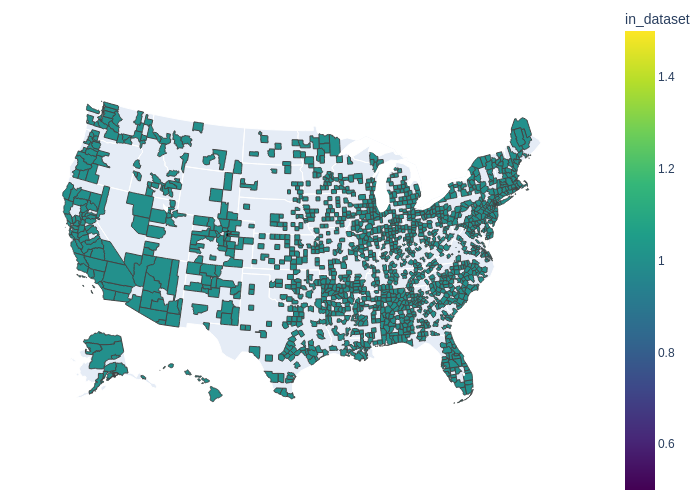

In [7]:
df = antivax.copy()
df = pd.DataFrame(list(zip(df['FIPS'].unique(), np.ones(len(df['FIPS'].unique())))), columns = ['fips','in_dataset'])
df['fips'] = df['fips'].apply(lambda x: str(x) if len(str(x))==5 else '0'+str(x))

fig = px.choropleth(df, geojson=counties, locations='fips', color='in_dataset',
                           color_continuous_scale="Viridis",
                           scope="usa",
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
Image(fig.to_image(format="png"))

# load cases and deaths data

In [8]:
deaths = pd.read_csv('/data_volume/pub/county_cases_and_deaths/covid_deaths_usafacts.csv')
deaths = pd.melt(frame = deaths, id_vars = deaths.columns[:4], 
                 var_name = 'date', value_name = 'deaths_to_date'
                ).drop(columns = ['County Name','StateFIPS']
                      ).rename(columns = {'countyFIPS':'FIPS','deaths_to_date':'cumulative_deaths'})
deaths['date'] = pd.to_datetime(deaths['date'])
deaths = deaths.drop(columns = ['State'])
# deaths = deaths[deaths['date'].isin(dates_to_keep)]

cases = pd.read_csv('/data_volume/pub/county_cases_and_deaths/covid_confirmed_usafacts.csv')
cases = pd.melt(frame = cases, id_vars = cases.columns[:4], 
                 var_name = 'date', value_name = 'cases_to_date'
                ).drop(columns = ['County Name','StateFIPS']
                      ).rename(columns = {'countyFIPS':'FIPS','cases_to_date':'cumulative_cases'})
cases['date'] = pd.to_datetime(cases['date'])
cases = cases.drop(columns = ['State'])
# cases = cases[cases['date'].isin(dates_to_keep)]


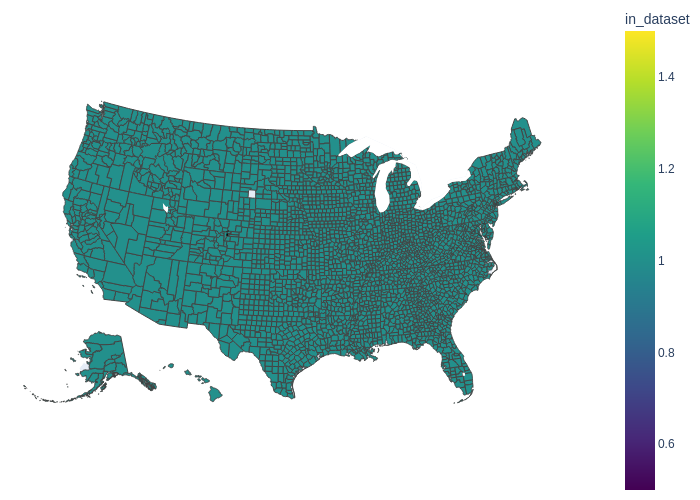

In [9]:
df = deaths.copy()
df = pd.DataFrame(list(zip(df['FIPS'].unique(), np.ones(len(df['FIPS'].unique())))), columns = ['fips','in_dataset'])
df['fips'] = df['fips'].apply(lambda x: str(x) if len(str(x))==5 else '0'+str(x))

fig = px.choropleth(df, geojson=counties, locations='fips', color='in_dataset',
                           color_continuous_scale="Viridis",
                           scope="usa",
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
Image(fig.to_image(format="png"))

# load vaccines data

In [10]:
#load vax data. large file, slowish. 
vax = pd.read_csv('/data_volume/pub/county_vaccinations/COVID-19_Vaccinations_in_the_United_States_County.csv', 
                  low_memory=False)
vax = vax[['Date','FIPS','Series_Complete_Pop_Pct','Series_Complete_Yes'] #select columns
         ].rename(columns={'Series_Complete_Pop_Pct':'fraction_vaccinated', 
                           'Series_Complete_Yes': 'cumulative_vaccinations',
                           'Date':'date'}) #rename
vax['date'] = pd.to_datetime(vax['date'], format = '%m/%d/%Y')
# vax = vax[vax['date'].isin(dates_to_keep)].sort_values(['FIPS','date'])  #filer by date and sort
vax['fraction_vaccinated'] = vax['fraction_vaccinated'] / 100 #convert percent to fraction
vax = vax[vax['FIPS']!='UNK'] #drop unknown fips
vax['FIPS'] = vax['FIPS'].astype('int') #convert to int
vax['state'] = (vax['FIPS']/1000).astype(int) #get state FIPS

In [11]:
#set TX data to nan- data is missing for most of 2021 and is incorrectly listed as zeros. 
vax.loc[(vax['state']==48)&(vax['date']<'2021-10-22'), 'fraction_vaccinated'] = np.nan
vax.loc[(vax['state']==48)&(vax['date']<'2021-10-22'), 'cumulative_vaccinations'] = np.nan

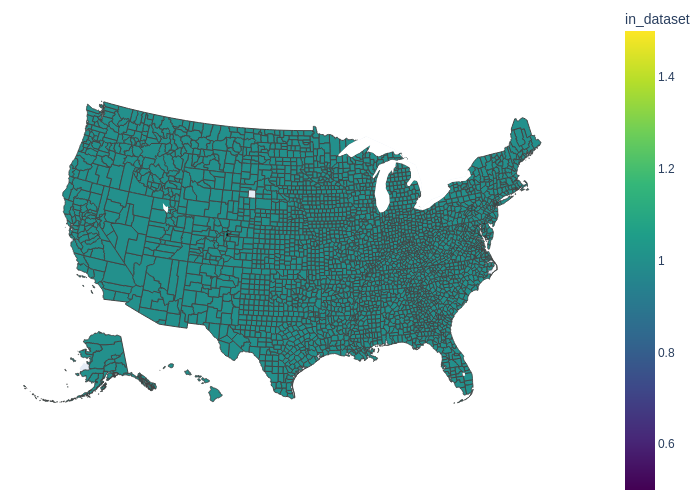

In [12]:
df = vax.copy()
df = pd.DataFrame(list(zip(df['FIPS'].unique(), np.ones(len(df['FIPS'].unique())))), columns = ['fips','in_dataset'])
df['fips'] = df['fips'].apply(lambda x: str(x) if len(str(x))==5 else '0'+str(x))

fig = px.choropleth(df, geojson=counties, locations='fips', color='in_dataset',
                           color_continuous_scale="Viridis",
                           scope="usa",
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
Image(fig.to_image(format="png"))

# load pop data

In [13]:
columns_to_log = ['PopDensity2010', 'BlackNonHispanicPct2010',
                  'HispanicPct2010', 'AsianNonHispanicPct2010', 'MedHHInc']

def nonlinear_transforms(df, columns_to_log):
    #log columns
    for col in columns_to_log:
        if col in df.columns: 
            df[col+'_log'] = np.log2(df[col]+df[col].median()/100)

    #handle misc cases
    df['WhiteNonHispanicPct2010_neglog'] = np.log2(100) - np.log2(100 - df['WhiteNonHispanicPct2010'])
    
    #remove untransformed cols
    df = df.drop(columns = ['WhiteNonHispanicPct2010']+columns_to_log)
    
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

In [14]:
pop = pd.read_parquet('/data_volume/pub/antivax/FIPS_populations.parquet').dropna()
pop = nonlinear_transforms(pop, columns_to_log)
pop['RepublicanPct2020']=pop['per_gop']*100
pop['GiniCoeff'] = pop['gini_est']
# pop[pop.columns[2:]] = MinMaxScaler().fit_transform(pop[pop.columns[2:]].values)
pop

,FIPS,population,per_dem,per_gop,RUCC_2013,Under18Pct2010,Age65AndOlderPct2010,Ed5CollegePlusPct,gini_est,PopDensity2010_log,BlackNonHispanicPct2010_log,HispanicPct2010_log,AsianNonHispanicPct2010_log,MedHHInc_log,WhiteNonHispanicPct2010_neglog,RepublicanPct2020,GiniCoeff
1,1001,56145,0.270184,0.714368,2.0,26.78,12.00,27.689286,0.4602,6.527592,4.137450,1.282677,-0.209895,15.868902,2.136062,71.436802,0.4602
2,1003,229287,0.224090,0.761714,3.0,22.99,16.77,31.345883,0.4609,6.846836,3.221777,2.141727,-0.425462,15.826084,2.599462,76.171373,0.4609
3,1005,24589,0.457882,0.534512,6.0,21.91,14.24,12.215925,0.4731,4.976700,5.545639,2.345652,-1.341537,15.090415,0.909147,53.451226,0.4731
4,1007,22136,0.206983,0.784263,1.0,22.70,12.68,11.489227,0.4294,5.219840,4.455449,0.850319,-3.257045,15.507092,2.001155,78.426264,0.4294
5,1009,57879,0.095694,0.895716,1.0,24.61,14.72,12.642895,0.4331,6.481514,0.355411,3.018438,-2.289122,15.635868,3.170069,89.571553,0.4331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3191,56037,42673,0.230260,0.736554,5.0,27.09,8.32,22.034377,0.4127,2.219509,-0.044910,3.935733,-0.425462,16.171730,2.386846,73.655363,0.4127
3192,56039,23497,0.670982,0.295769,7.0,19.14,9.85,57.370077,0.4879,2.532903,-2.561920,3.909091,0.103800,16.603747,2.490862,29.576889,0.4879
3193,56041,20215,0.169219,0.797277,7.0,30.17,8.87,15.447154,0.4002,3.406992,-2.003756,3.139617,-1.812992,15.963671,3.124063,79.727718,0.4002
3194,56043,7760,0.162263,0.808824,7.0,25.45,17.67,21.547156,0.3898,2.093340,-1.839854,3.771136,-0.876731,15.765268,2.633972,80.882353,0.3898


# make corr_df

In [15]:
the_50_states_plus_dc = [x for x in vax['state'].unique() if (x<=56 and x>0)]
len(the_50_states_plus_dc)

51

In [16]:
def add_cummulative_tweet_rates(df):
    #if we didnt observe any tweets in the county for that date, fill with 0.  
    df['n_antivax_tweets_on_day'] = df['n_antivax_tweets_on_day'].fillna(0)
    df['n_tweets_on_day'] = df['n_tweets_on_day'].fillna(0)
#     df['n_lowcred_urls_on_day'] = df['n_lowcred_urls_on_day'].fillna(0)
#     df['n_urls_on_day'] = df['n_urls_on_day'].fillna(0)
    df['n_antivax_retweets_on_day'] = df['n_antivax_tweets_on_day'].fillna(0)
    df['n_retweets_on_day'] = df['n_tweets_on_day'].fillna(0)
    df['n_new_antivax_users_on_day'] = df['n_new_antivax_users_on_day'].fillna(0)
    df['n_new_users_on_day'] = df['n_new_users_on_day'].fillna(0)
    df['n_active_antivax_users_on_day'] = df['n_active_antivax_users_on_day'].fillna(0)
    df['n_active_users_on_day'] = df['n_active_users_on_day'].fillna(0)

    #get cumulative antivax rates and lowcred rates
    df = df.sort_values(by='date').reset_index(drop=True)
    df['cumulative_antivax_tweets'] = df.groupby('FIPS').agg({'n_antivax_tweets_on_day':'cumsum'})['n_antivax_tweets_on_day']
    df['cumulative_tweets'] = df.groupby('FIPS').agg({'n_tweets_on_day':'cumsum'})['n_tweets_on_day']
    df['cumulative_antivax_retweets'] = df.groupby('FIPS').agg({'n_antivax_retweets_on_day':'cumsum'})['n_antivax_retweets_on_day']
    df['cumulative_retweets'] = df.groupby('FIPS').agg({'n_retweets_on_day':'cumsum'})['n_retweets_on_day']
#     df['cumulative_lowcred_urls'] = df.groupby('FIPS').agg({'n_lowcred_urls_on_day':'cumsum'})['n_lowcred_urls_on_day']
#     df['cumulative_urls'] = df.groupby('FIPS').agg({'n_urls_on_day':'cumsum'})['n_urls_on_day']
    df['cumulative_antivax_users'] = df.groupby('FIPS').agg({'n_new_antivax_users_on_day':'cumsum'})['n_new_antivax_users_on_day']
    df['cumulative_users'] = df.groupby('FIPS').agg({'n_new_users_on_day':'cumsum'})['n_new_users_on_day']
    df['cumulative_antivax_userdays'] = df.groupby('FIPS').agg({'n_active_antivax_users_on_day':'cumsum'})['n_active_antivax_users_on_day']
    df['cumulative_userdays'] = df.groupby('FIPS').agg({'n_active_users_on_day':'cumsum'})['n_active_users_on_day']
        
    #get total tweets in observation period
    n_tweet_all_time = df.groupby('FIPS'
                                      ).agg({'n_tweets_on_day':'sum'}
                                      ).rename(columns = {'n_tweets_on_day':'n_tweets_all_time'}
                                      ).reset_index(
                                      )[['FIPS','n_tweets_all_time']]
    df = df.merge(n_tweet_all_time, on='FIPS',how='left')
    df['n_tweets_all_time_per_capita'] = df['n_tweets_all_time']/df['population']
    df['n_tweets_all_time_per_capita_log'] = np.log2(df['n_tweets_all_time_per_capita'])
    
    return df


In [17]:
confounders = ['RepublicanPct2020', 'RUCC_2013', 'Under18Pct2010', 'Age65AndOlderPct2010', 'Ed5CollegePlusPct','GiniCoeff',
               'PopDensity2010_log', 'BlackNonHispanicPct2010_log', 'HispanicPct2010_log', 
               'AsianNonHispanicPct2010_log', 'MedHHInc_log', 'WhiteNonHispanicPct2010_neglog', 
               'n_tweets_all_time_per_capita_log']
indexes = ['FIPS','date','population','state']
dynamic_vars = ['cumulative_vaccinations', 'cumulative_cases', 'cumulative_deaths', 
                'cumulative_antivax_tweets','cumulative_tweets', 
                'cumulative_antivax_retweets','cumulative_retweets', 
                'cumulative_antivax_users', 'cumulative_users', 'cumulative_antivax_userdays', 'cumulative_userdays'
                ]

def make_corr_df(vax, antivax, deaths, cases, pop):
    #merge all datasets
    corr_df = vax.merge(antivax, on=['FIPS','date'], how='outer')
    corr_df = corr_df.merge(deaths, on=['FIPS','date'], how='outer')
    corr_df = corr_df.merge(cases, on=['FIPS','date'], how='outer')
    corr_df = corr_df.merge(pop, on='FIPS', how='inner')
    
    #drop counties that arent in the 50 states plus dc
    corr_df = corr_df[~corr_df['state'].isna()]
    corr_df['state'] = corr_df['state'].astype(int)
    corr_df = corr_df[corr_df['state'].isin(the_50_states_plus_dc)]
    
    #drop dates outside 2021
    corr_df = corr_df[corr_df['date']<'2022-01-01']
    corr_df = corr_df[corr_df['date']>='2021-01-01']

    #drop counties with missing dates
    a = corr_df['FIPS'].value_counts()
    a = (a == a.max())
    a = a[a]
    corr_df = corr_df[corr_df['FIPS'].isin(a.index)].reset_index(drop=True)
        
    #get cummulative counts for each FIPS at all dates
    corr_df = add_cummulative_tweet_rates(corr_df)
        
    return corr_df

corr_df = make_corr_df(vax, antivax, deaths, cases, pop)
corr_df = corr_df[indexes+confounders+dynamic_vars]
corr_df = corr_df.sort_values(by='date')
print('n_fips', corr_df['FIPS'].nunique())
print('n_dates', corr_df['date'].nunique())
print(corr_df['date'].nunique()*corr_df['FIPS'].nunique() == len(corr_df))
corr_df.info()
corr_df

/usr/lib/python3/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log2



n_fips 3110
n_dates 365
True
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1135150 entries, 0 to 1135149
Data columns (total 28 columns):
 #   Column                            Non-Null Count    Dtype         
---  ------                            --------------    -----         
 0   FIPS                              1135150 non-null  int64         
 1   date                              1135150 non-null  datetime64[ns]
 2   population                        1135150 non-null  int64         
 3   state                             1135150 non-null  int64         
 4   RepublicanPct2020                 1135150 non-null  float64       
 5   RUCC_2013                         1135150 non-null  float64       
 6   Under18Pct2010                    1135150 non-null  float64       
 7   Age65AndOlderPct2010              1135150 non-null  float64       
 8   Ed5CollegePlusPct                 1135150 non-null  float64       
 9   GiniCoeff                         1135150 non-null  float64  

,FIPS,date,population,state,RepublicanPct2020,RUCC_2013,Under18Pct2010,Age65AndOlderPct2010,Ed5CollegePlusPct,GiniCoeff,...,cumulative_cases,cumulative_deaths,cumulative_antivax_tweets,cumulative_tweets,cumulative_antivax_retweets,cumulative_retweets,cumulative_antivax_users,cumulative_users,cumulative_antivax_userdays,cumulative_userdays
0,31137,2021-01-01,9006,31,82.792272,7.0,24.58,19.00,25.905159,0.4224,...,746.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2067,26049,2021-01-01,404794,26,44.594326,2.0,25.03,13.67,20.926703,0.4650,...,21619.0,596.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2068,56033,2021-01-01,30863,56,72.090334,7.0,22.27,15.62,29.986323,0.4383,...,2543.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2069,29011,2021-01-01,11592,29,85.041961,6.0,25.92,17.19,18.082735,0.4774,...,911.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2070,55129,2021-01-01,15712,55,61.032954,7.0,20.31,21.24,22.306126,0.4543,...,1102.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133079,5021,2021-12-31,14375,5,78.834652,7.0,22.32,20.02,11.604612,0.4574,...,2970.0,77.0,10.0,80.0,10.0,80.0,5.0,48.0,5.0,68.0
1133080,26019,2021-12-31,17852,26,53.832980,9.0,20.99,20.64,29.255158,0.4048,...,2407.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1133081,24041,2021-12-31,36972,24,48.530259,6.0,19.52,23.71,38.600427,0.5266,...,3693.0,64.0,63.0,655.0,63.0,655.0,8.0,122.0,10.0,470.0
1133059,18003,2021-12-31,382187,18,54.460558,2.0,27.01,11.86,28.157838,0.4521,...,75061.0,985.0,2456.0,21497.0,2456.0,21497.0,85.0,1801.0,157.0,11673.0


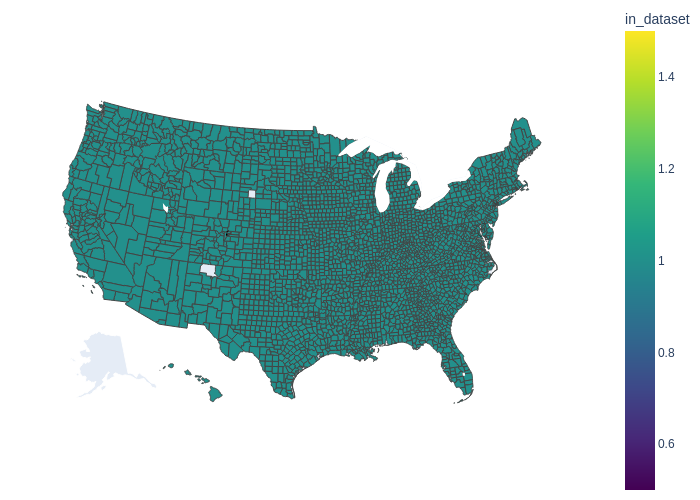

In [18]:
df = corr_df.copy()
df = pd.DataFrame(list(zip(df['FIPS'].unique(), np.ones(len(df['FIPS'].unique())))), columns = ['fips','in_dataset'])
df['fips'] = df['fips'].apply(lambda x: str(x) if len(str(x))==5 else '0'+str(x))

fig = px.choropleth(df, geojson=counties, locations='fips', color='in_dataset',
                           color_continuous_scale="Viridis",
                           scope="usa",
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
Image(fig.to_image(format="png"))

In [19]:
corr_df.to_parquet('time_series_df.parquet')

# make retweet network

In [20]:
def make_retweet_net(date_min=None, date_max=None):
    tweets = pd.read_parquet('/data_volume/pub/antivax/labeled_geotagged_tweets.parquet')
    if date_min is not None:
        tweets = tweets[tweets['tweet_time']>=date_min]
    if date_max is not None:
        tweets = tweets[tweets['tweet_time']<=date_max]
    
    a = tweets[['tweet_id','FIPS']
          ].rename(columns={'tweet_id':'retweeted_tweet_id', 'FIPS':'retweeted_FIPS'}
          ).drop_duplicates()
    retweet_network = tweets[['tweet_id','retweeted_tweet_id','FIPS']
                            ].merge(right=a, on='retweeted_tweet_id',how='inner')
    county_retweet_network = retweet_network.groupby(['FIPS','retweeted_FIPS']
                                           ).agg({'tweet_id':'count'}
                                           ).reset_index(
                                           ).rename(columns={'tweet_id':'n_retweets', 'FIPS':'retweeting_FIPS'})
    n_days = (tweets['tweet_time'].max()-tweets['tweet_time'].min()).days
    county_retweet_network['n_retweets_per_day'] = county_retweet_network['n_retweets']/n_days
    return county_retweet_network

In [21]:
county_retweet_network = make_retweet_net()

In [22]:
county_retweet_network.to_parquet('raw_retweet_neighbor_edgelist.parquet') 

# check if retweet network changes much over time

it doesnt

In [23]:
county_retweet_network_early = make_retweet_net(date_max = '04-04-2021')
county_retweet_network_late = make_retweet_net(date_min = '04-04-2021')

In [24]:
county_retweet_network_comp = county_retweet_network_late.merge(county_retweet_network_early,
                                                               on = ['retweeting_FIPS','retweeted_FIPS'], 
                                                               how='outer').fillna(0)

In [25]:
county_retweet_network_comp[['n_retweets_per_day_x','n_retweets_per_day_y']].corr()

,n_retweets_per_day_x,n_retweets_per_day_y
n_retweets_per_day_x,1.000000,0.974901
n_retweets_per_day_y,0.974901,1.000000
